In [115]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [116]:
# Define a frame for image and mask storage
framObjTrain = {'img': [], 'mask': []}

# Define data loader function
def LoadData(frameObj=None, imgPath=None, maskPath=None, shape=128):
    if frameObj is None:
        frameObj = {'img': [], 'mask': []}

    # Check if the provided paths exist
    if not os.path.exists(imgPath) or not os.path.exists(maskPath):
        raise ValueError("The provided imgPath or maskPath does not exist.")
    
    # List the image and mask files in the directories
    imgNames = os.listdir(imgPath)
    maskNames = os.listdir(maskPath)

    # Sort the filenames to maintain consistency
    imgNames.sort()
    maskNames.sort()

    print(f"Number of images: {len(imgNames)}")
    print(f"Number of masks: {len(maskNames)}")
    
    # Check each image file for a corresponding mask
    for imgName in imgNames:
        try:
            # Construct the full path to the image
            imgPathFull = os.path.join(imgPath, imgName)
            
            # Assume the mask file has the same name as the image
            maskPathFull = os.path.join(maskPath, imgName)
            
            if not os.path.exists(maskPathFull):
                print(f"Warning: Mask file not found for {imgName}. Skipping.")
                continue

            # Read the image and mask
            img = plt.imread(imgPathFull)
            mask = plt.imread(maskPathFull)

            # Resize the image and mask
            img = cv2.resize(img, (shape, shape))
            mask = cv2.resize(mask, (shape, shape))

            # Convert images to 3 channels if they are grayscale or single channel
            if len(img.shape) == 2 or img.shape[2] == 1:
                img = np.repeat(img[..., np.newaxis], 3, axis=-1)  # Convert to (height, width, 3)

            # Convert masks to 3 channels if they are grayscale or single channel
            if len(mask.shape) == 2 or mask.shape[2] == 1:
               mask = np.repeat(mask[..., np.newaxis], 3, axis=-1)  # Convert to (height, width, 3)

            # Normalize image intensities to range [0, 1]
            #img = img.astype(np.float32) / 255.0
            
            # Append to the frame object
            frameObj['img'].append(img)
            frameObj['mask'].append(mask)

        except Exception as e:
            print(f"Error loading or processing file {imgName}: {e}")

    return frameObj

# Example usage with provided paths
framObjTrain = LoadData(framObjTrain, 
                        imgPath='/kaggle/input/test-cm/images', 
                        maskPath='/kaggle/input/train-cm/masks', 
                        shape=128)

# Display the number of images and masks loaded
print(f"Loaded {len(framObjTrain['img'])} images and {len(framObjTrain['mask'])} masks.")


Number of images: 250
Number of masks: 200
Loaded 200 images and 200 masks.


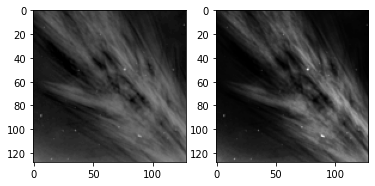

In [117]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [118]:
# code block taken from the git address : https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb
# do show your support.
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, input):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(x)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([x, attention])
        
        @classmethod
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'filters' : self.filters,
                'ratio'   : self.ratio,
            })
            return config
 

class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, input):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(input)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(input)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([x, attention])
        
        @classmethod
        def get_config(self):
            config = super().get_config().copy()
            cofig.update({
                'kernel_size' : self.kernel_size
            })
            return config

In [119]:
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 16, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    x = ChannelAttention(numFilters,kernelSize)(x)
    x = SpatialAttention(8)(x)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    
    x = ChannelAttention(numFilters,kernelSize)(x)
    x = SpatialAttention(8)(x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 3, dropouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(dropouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(dropouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(dropouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(dropouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [120]:
## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3))
myTransformer = GiveMeUnet(inputs, dropouts=0.07)
myTransformer.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])


In [144]:
# Assuming framObjTrain is already populated with images and masks

# Convert the lists to NumPy arrays
images = np.array(framObjTrain['img'])
masks = np.array(framObjTrain['mask'])

# Check the shape and dtype of the arrays before reshaping
print(f"Original Images shape: {images.shape}, dtype: {images.dtype}")
print(f"Original Masks shape: {masks.shape}, dtype: {masks.dtype}")

# Reshape the images to add the channel dimension
# We need to duplicate the single grayscale channel to create a 3-channel input
#images = np.repeat(images[..., np.newaxis], 3, axis=-1)  # From (batch_size, height, width) to (batch_size, height, width, 3)
# masks = masks.reshape(masks.shape[0], masks.shape[1], masks.shape[2], 1)

# Check the new shape after reshaping
print(f"Reshaped Images shape: {images.shape}")
print(f"Reshaped Masks shape: {masks.shape}")

# Model training with verbose output to show epoch and training progress
print("Starting model training...\n")
retVal = myTransformer.fit(images, masks, epochs=500, verbose=1)

# Print the return value to check the training outcome
print("\nTraining completed.")
print(f"Training return value: {retVal}")


Original Images shape: (200, 128, 128, 3), dtype: float32
Original Masks shape: (200, 128, 128, 3), dtype: float32
Reshaped Images shape: (200, 128, 128, 3)
Reshaped Masks shape: (200, 128, 128, 3)
Starting model training...

Epoch 1/500
7/7 [==============================] - 6s 894ms/step - loss: 0.2267 - accuracy: 0.2486
Epoch 2/500
7/7 [==============================] - 6s 910ms/step - loss: 0.2265 - accuracy: 0.2559
Epoch 3/500
7/7 [==============================] - 6s 895ms/step - loss: 0.2265 - accuracy: 0.2678
Epoch 4/500
7/7 [==============================] - 6s 913ms/step - loss: 0.2266 - accuracy: 0.2593
Epoch 5/500
7/7 [==============================] - 6s 904ms/step - loss: 0.2269 - accuracy: 0.2784
Epoch 6/500
7/7 [==============================] - 7s 946ms/step - loss: 0.2265 - accuracy: 0.2644
Epoch 7/500
7/7 [==============================] - 6s 898ms/step - loss: 0.2270 - accuracy: 0.2589
Epoch 8/500
7/7 [==============================] - 6s 902ms/step - loss: 0.2260 -

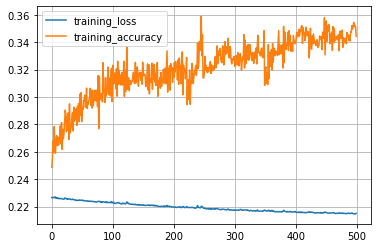

In [145]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [2]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:160]
    
    imgProc = img [0:160]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Low Res image')
    
    ## Adding Image sharpening step here
    ## it is a sharpening filter
    filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) 
    #imgSharpen = cv2.filter2D(predMask,-1,filter)
    imgSharpen = predMask
    plt.subplot(1,3,2)
    plt.imshow(imgSharpen)
    plt.title('Predicted High Res Image')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual High Res Image')

In [3]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, myTransformer)

NameError: name 'framObjTrain' is not defined

In [151]:
def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1/ (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def pixel_MSE(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [1]:
i=78
Plotter(actuals[i], sixteenPrediction[i], masks[i])
print('PSNR',PSNR(masks[i],actuals[i]),'dB', "SSIM",tf.image.ssim(masks[i],actuals[i],max_val=1))
print('PSNR',PSNR(masks[i],sixteenPrediction[i]),'dB', "SSIM",tf.image.ssim(masks[i],sixteenPrediction[i],max_val=1))

NameError: name 'Plotter' is not defined

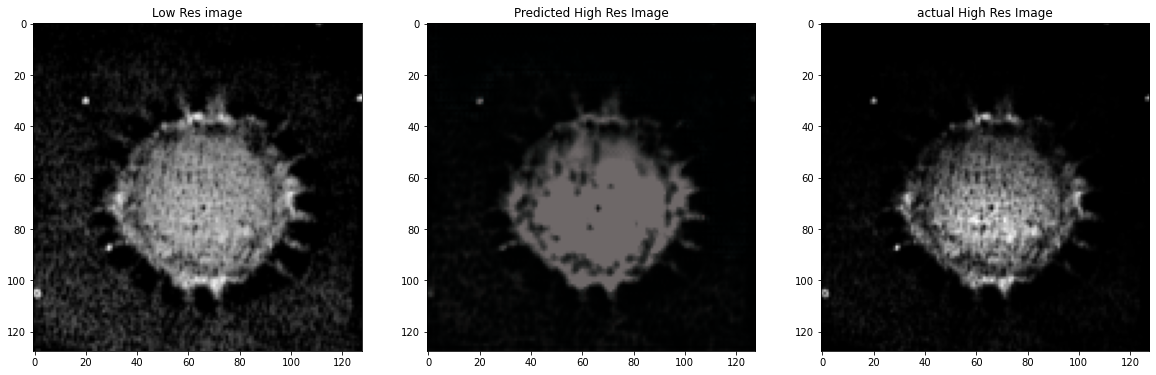

In [143]:
Plotter(actuals[2], sixteenPrediction[2], masks[2])

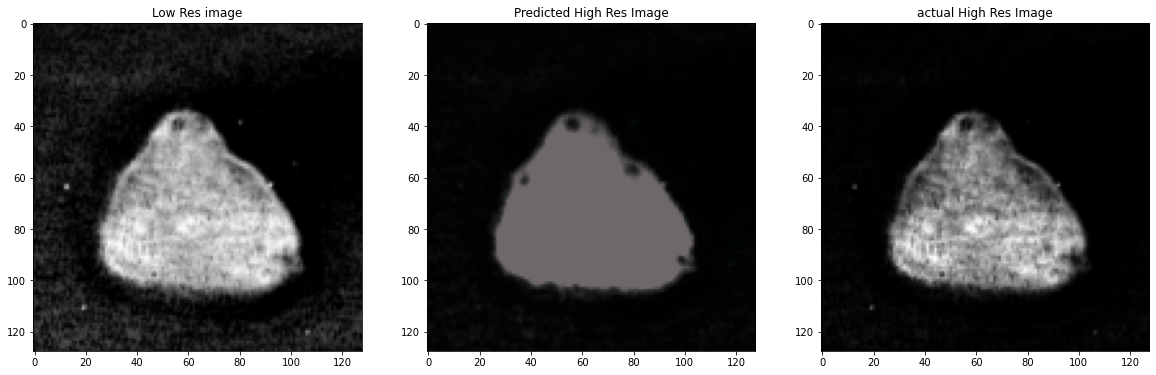

In [127]:
Plotter(actuals[3], sixteenPrediction[3], masks[3])

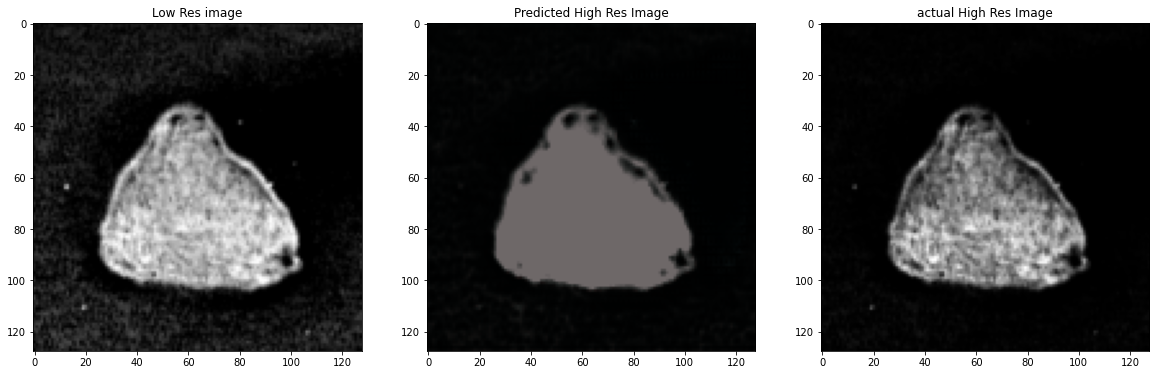

In [128]:
Plotter(actuals[4], sixteenPrediction[4], masks[4])

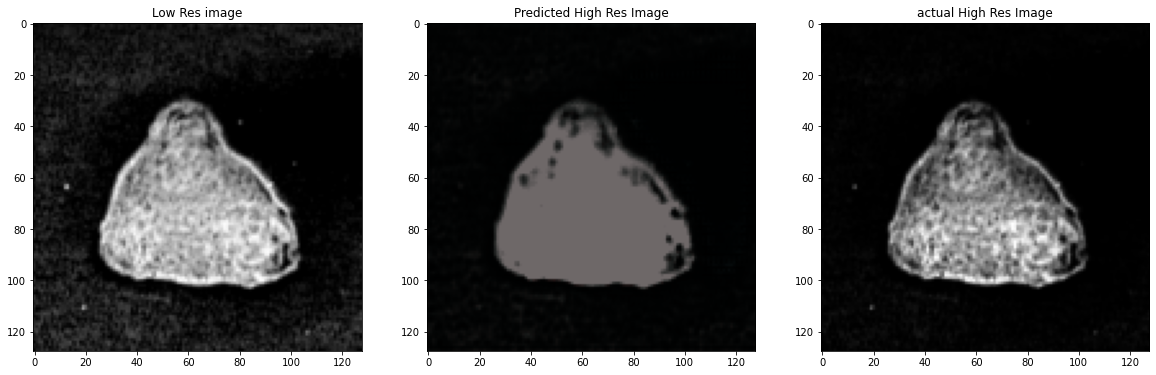

In [129]:
Plotter(actuals[5], sixteenPrediction[5], masks[5])

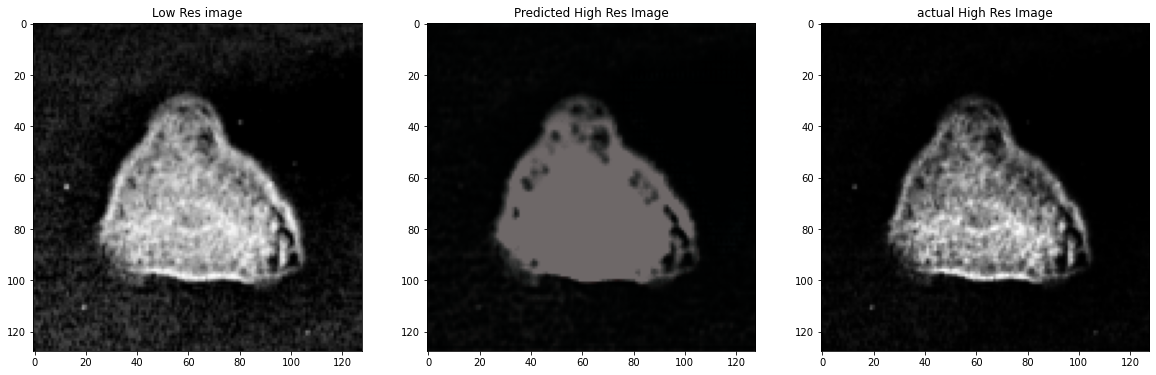

In [130]:
Plotter(actuals[6], sixteenPrediction[6], masks[6])

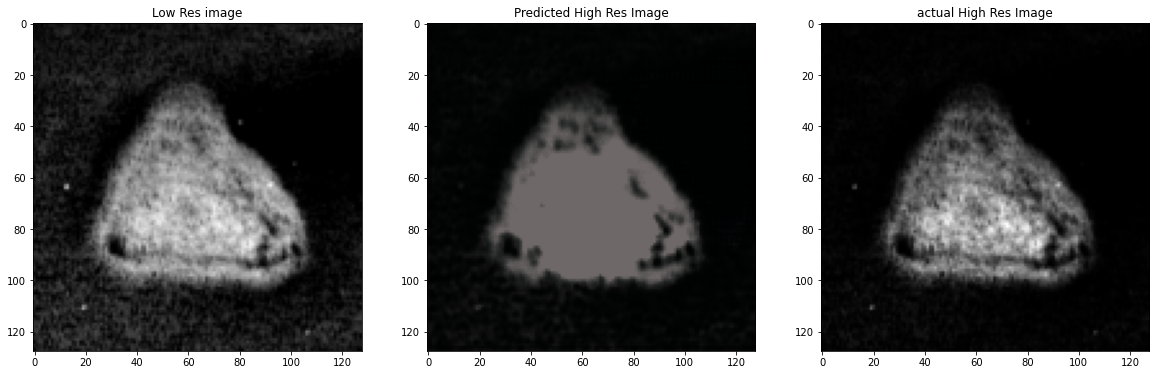

In [131]:
Plotter(actuals[7], sixteenPrediction[7], masks[7])

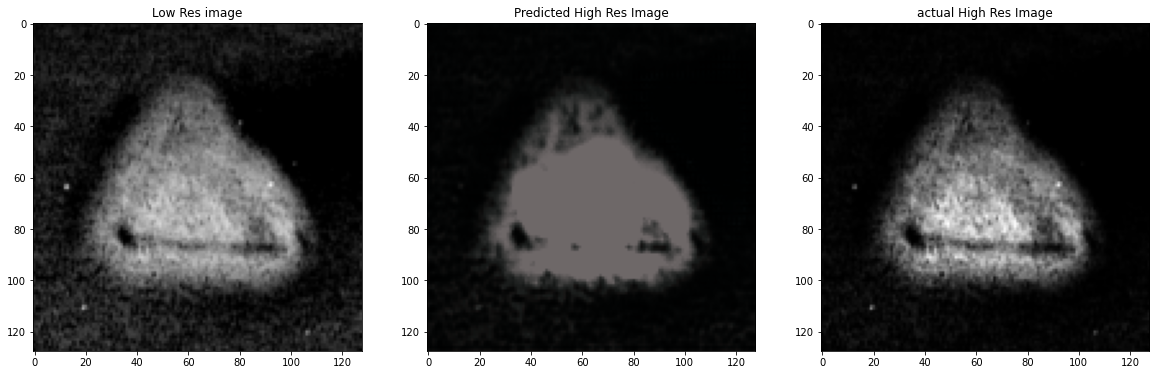

In [132]:
Plotter(actuals[8], sixteenPrediction[8], masks[8])

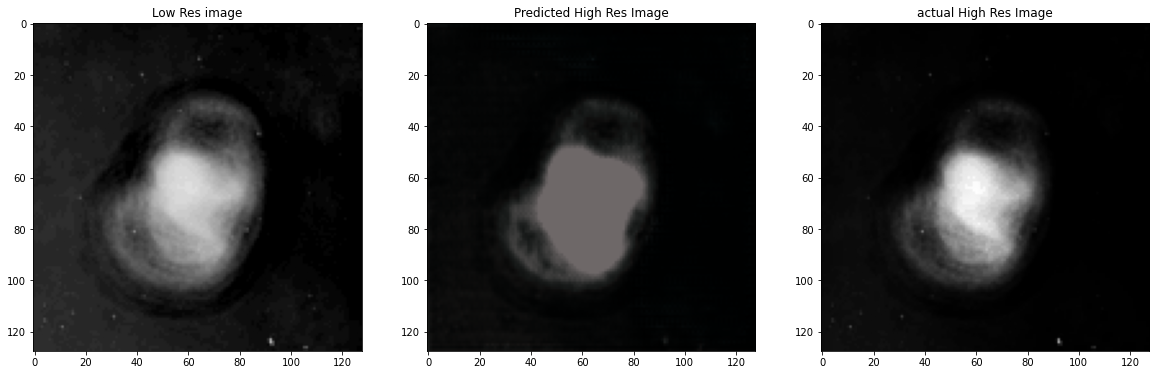

In [133]:
Plotter(actuals[10], sixteenPrediction[10], masks[10])

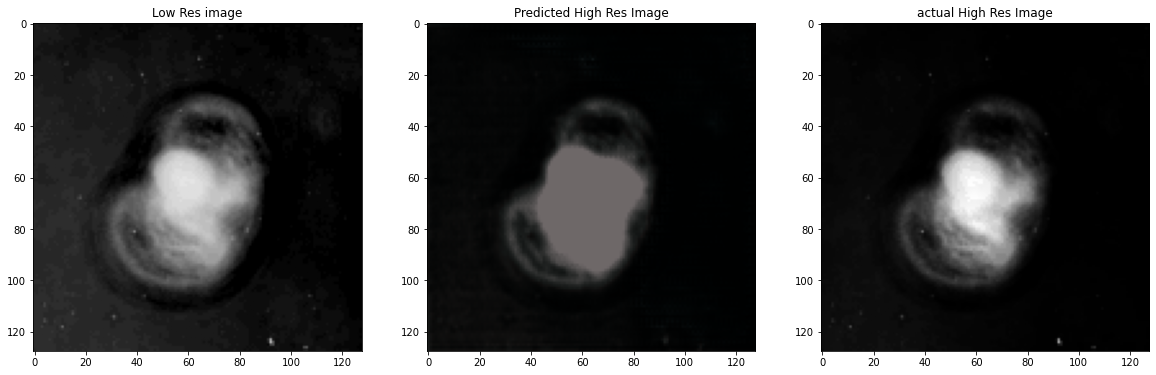

In [134]:
Plotter(actuals[11], sixteenPrediction[11], masks[11])

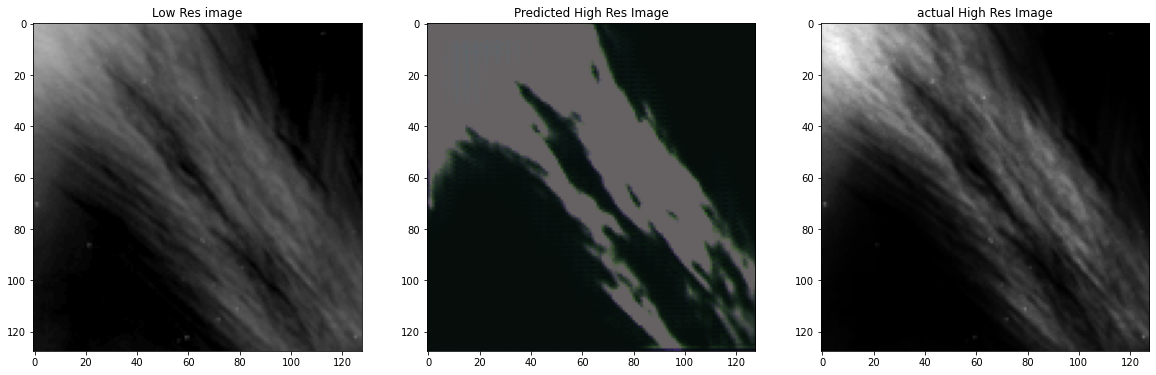

In [104]:
Plotter(actuals[12], sixteenPrediction[12], masks[12])

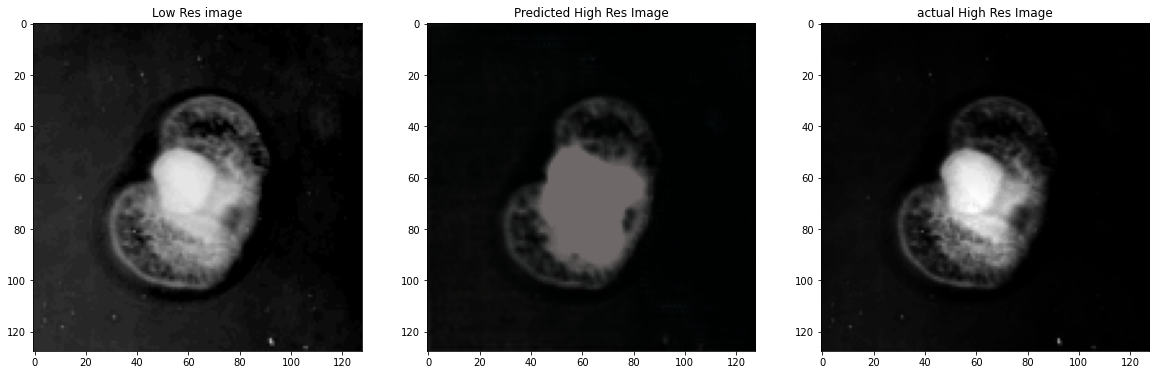

In [135]:
Plotter(actuals[13], sixteenPrediction[13], masks[13])

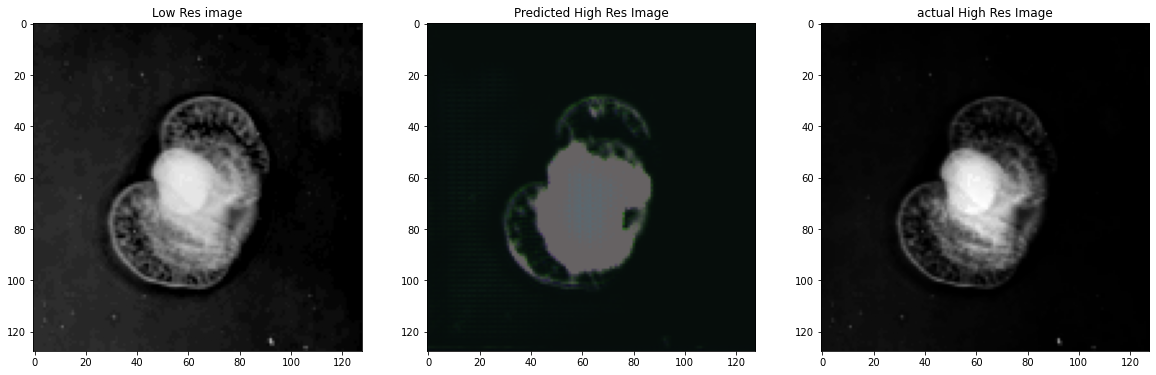

In [102]:
Plotter(actuals[14], sixteenPrediction[14], masks[14])

In [137]:
Plotter(actuals[15], sixteenPrediction[150], masks[150])

IndexError: list index out of range